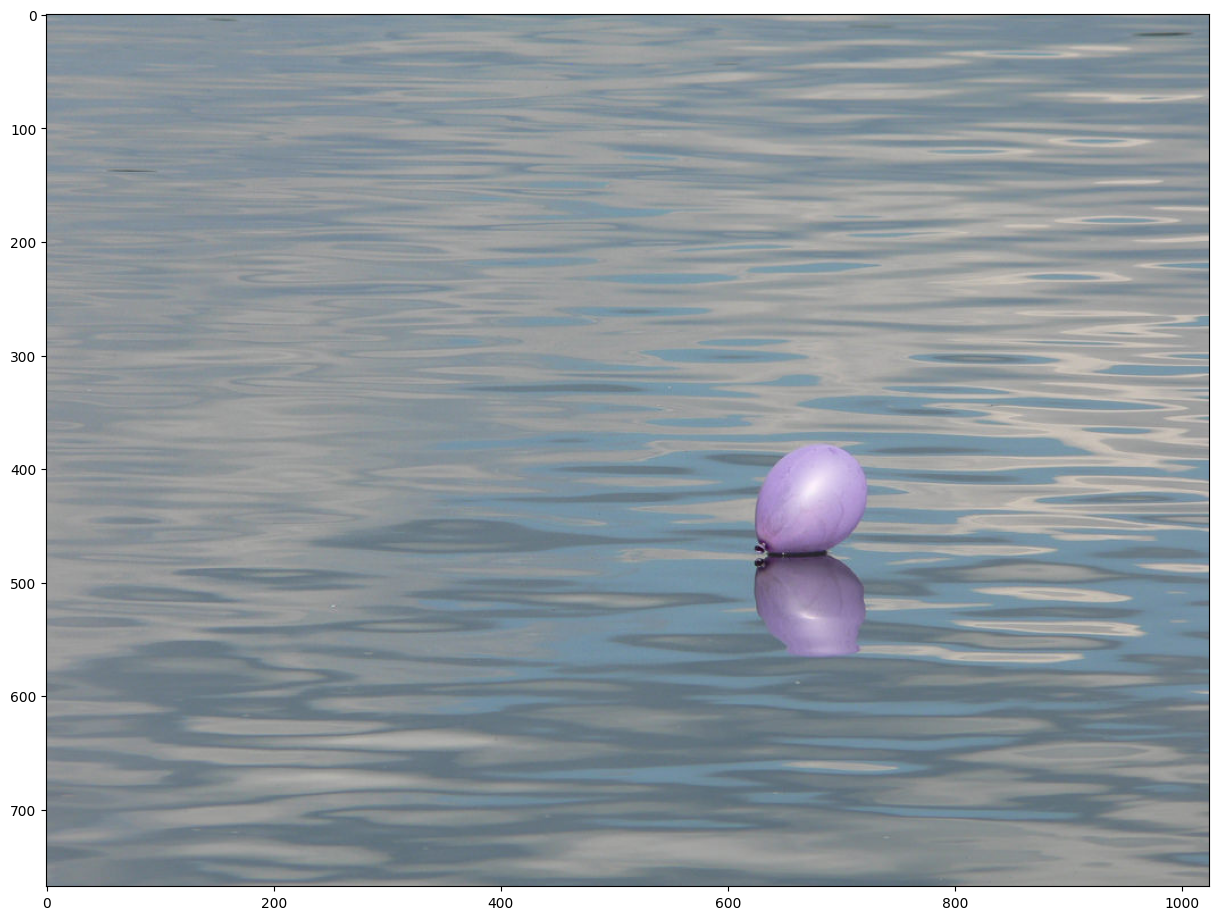

In [ ]:
import cv2
import numpy as np

# Carregando uma rede já treinada (pesos e configurações), usando o pacote dnn do opencv:
rede = cv2.dnn.readNet("../0-Data/yolov3.weights", "../0-Data/yolov3.cfg")

# Definindo os nomes das classes (esses nomes já existem e estão no arquivo coco.names):
classes = []
with open("../0-Data/coco.names", "r") as nomes_classes:
    classes = [linha.strip() for linha in nomes_classes.readlines()] # lê cada linha ignorando possíveis espaços desnecessários

# Extraindo mais dados da rede já treinada:
nomes_camadas = rede.getLayerNames() # captura os nomes de todos os layers da rede
camadas_pre_saida = [nomes_camadas[i - 1] for i in rede.getUnconnectedOutLayers()] # captura os nomes dos layers anteriores à saída
# getUnconnectedOutLayers() pega a própria saída, estamos interessados em um layer antes disso. Vale lembrar que são 3 saídas ao todo
cores = np.random.uniform(0, 255, size=(len(classes), 3)) # gera um array de dimensão (n_classes, 3) de números aleatórios que variam entre 0 e 255

# Carregando a imagem a ser testada:
imagem = cv2.imread("../0-Data/balloon/train/53500107_d24b11b3c2_b.jpg")
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
altura, largura, canais = imagem.shape # salvando as dimensões da imagem

# Fazendo a detecção de objetos:
# O YOLO trabalha com 3 formatos de entrada (320×320, 416×416 e 609×609). Quanto maior, melhor a acurácia, mas mais demorado.
# A função blobFromImage recebe a imagem, reescala, muda seu shape, faz subtração pela média (centering) e inverte bgr/rgb:
# parâmetros: (image, scalefactor, size, mean, swapRB=True)
# YOLO não requer subtração pela média. Se passarmos (0,0,0) para a média, ele não irá fazer subtração pela média, afinal estamos subtraindo cada cor por zero.
# O scalefactor é uma multiplicação que faremos para normalizar a imagem (dividir tudo por 255), pois YOLO requer imagens normalizadas (cores entre 0-1)
formatador = cv2.dnn.blobFromImage(imagem, 0.00392, (416, 416), (0, 0, 0), True) # repare que 0.00392 = 1/255
rede.setInput(formatador) # adiciona a imagem remodelada como entrada na rede
saidas = rede.forward(camadas_pre_saida) # faz a detecção dos objetos

# Agora precisamos mostrar as informações na tela:
ids_classes = []
probabilidades = []
caixas = []
for saida in saidas: # para cada uma das 3 saídas da rede
    for deteccao in saida: # varre cada vetor y
        # passa por todas as classes e pega aquela que tem maior probabilidade:
        scores = deteccao[5:] # ignora os primeiros valores (prob objeto e coordenadas do retângulo)
        id_classe = np.argmax(scores) # armazena o id da classe com maior probabilidade
        probabilidade = scores[id_classe] # armazena o valor dessa probabilidade
        if probabilidade > 0.5: # se aquela classe apresenta probabilidade > 0.5, houve uma detecção!
            centro_x = int(deteccao[0] * largura) # captura o valor da coordenada x, que é proporcional ao comprimento da figura
            centro_y = int(deteccao[1] * altura) # captura o valor da coordenada y, que é proporcional à altura da figura
            largura_caixa = int(deteccao[2] * largura) # captura o valor da largura da caixa, que é proporcional ao comprimento da figura
            altura_caixa = int(deteccao[3] * altura) # captura o valor da altura da caixa, que é proporcional à altura da figura
            # Cria duas variáveis (x e y, posição do topo esquerdo) para desenhar o retângulo depois:
            x = int(centro_x - largura_caixa/2)
            y = int(centro_y - altura_caixa/2)
            caixas.append([x, y, largura_caixa, altura_caixa]) # salva todas essas coordenadas na variável caixas
            probabilidades.append(float(probabilidade)) # salva a probabilidade
            ids_classes.append(id_classe) # salva o id da classe

# aplicando NMS para evitar detecções repetidas:           
indices = cv2.dnn.NMSBoxes(caixas, probabilidades, 0.5, 0.4) # parâmetros: (boxes, confidences, score_threshold, nms_threshold)

fonte_letra = cv2.FONT_HERSHEY_PLAIN # tipo de letra escolhido para escrever

# Para cada um dos retângulos que classificam objetos, vamos desenhar o retângulo:
for i in range(len(caixas)): 
    if i in indices: 
        x, y, largura_caixa, altura_caixa = caixas[i]
        nome_classe = str(classes[ids_classes[i]]) # pega o nome da classe a partir do seu id
        cor = cores[i] # seleciona uma das cores aleatórias geradas
        cv2.rectangle(imagem_rgb, (x, y), (x + largura_caixa, y + altura_caixa), cor, 5) # cria o retângulo na posição especificada, com as dimensões especificadas
        cv2.putText(imagem_rgb, nome_classe, (x + 30, y + 90), fonte_letra, 3, cor, 5) # coloca o texto na posição especificada (nome da classe)

# Mostrando a figura:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15)) 
plt.imshow(imagem_rgb)
plt.show()